In [291]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time

In [292]:
# for parallelization if necessary
#from dask import compute, delayed
#from dask.distributed import Client, LocalCluster 
#cl = LocalCluster(n_workers=4)
#client = Client(cl)
#cl

# note: if this throws an error, close jupyter, run "ulimit -n 4096" in terminal, then restart jupyter

In [293]:
# define data location
#location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
location = '/Users/loki/Documents/Data/Forecasting Project/'

In [365]:
# read data from pickle

# what data granularity?
granularity = "daily"

# if we're clustering first, we need to load in sufficient_ data to ensure data equivalency across IDs
if granularity == "daily":
    readdata = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip')
    weather = pd.read_pickle(location+'daily_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_daily_ids.pkl.zip')
elif granularity == "hourly":
    readdata = pd.read_pickle(location+'peco_sufficient_hourly.pkl.zip')
    weather = pd.read_pickle(location+'hourly_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_hourly_ids.pkl.zip')
else:
    print("Granularity selected was not 'daily' or 'hourly'")


In [304]:
readdata.head()

DACCOUNTID     1767458
DMETERNO       1767458
Dt             1767458
ID             1767458
Use            1767458
DCUSTOMERID    1767458
TARIFF         1767458
FUELTYPE       1767458
REVENUCODE     1757476
Friday         1767458
Monday         1767458
Saturday       1767458
Sunday         1767458
Thursday       1767458
Tuesday        1767458
Wednesday      1767458
Holiday        1767458
TYPE           1767458
dtype: int64

## Cluster ##

In [296]:
# Cumulative Distribution Function Plot
def cdf(x):
    """cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

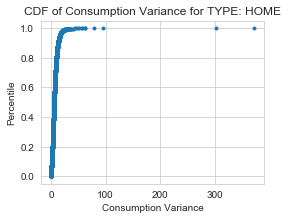

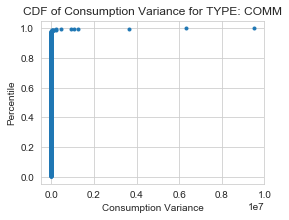

In [297]:
for code in readdata['TYPE'].drop_duplicates():
    data = readdata[(readdata['TYPE']==code)]
        
    variance = data[['ID','Use']].groupby('ID').var().reset_index()
    variance = variance.rename(columns={'Use':'use_var'})
    
    # plot
    f, ax = plt.subplots(figsize=(4,3))
    sns.set_style('whitegrid')

    xs, ys = cdf(np.array(variance['use_var']))
    plt.plot(xs, ys, '.')
    plt.ylabel('Percentile'); plt.title('CDF of Consumption Variance for TYPE: '+code); plt.xlabel('Consumption Variance');

Curve seems fairly continuous for both home and commecial
* We won't be able to easily identify a threshold where behavior shifts for winter
* There are outliers that may throw off kmeans; we should review cluster centroids to consider

### Kmeans ###

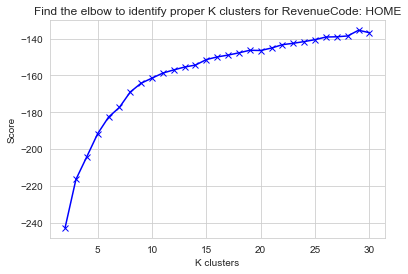

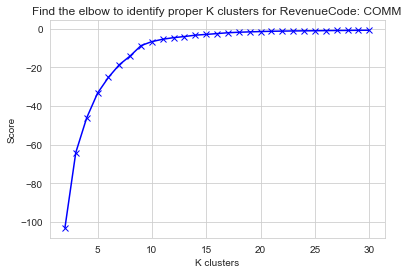

In [307]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

for code in readdata['TYPE'].drop_duplicates():
    # break out by revenuecode
    data = readdata[(readdata['TYPE']==code)]
    # restructure data: keep bare minimum of use info; transition use into wide format
    ids = data[['ID','TYPE']].drop_duplicates()
    data = data.loc[:, data.columns.isin(['ID','TYPE','Dt','Use'])]
    data = data.pivot_table(values='Use', index=['ID','TYPE'], columns='Dt').reset_index()
    data = data.drop(columns='TYPE')
    data = data.dropna()

    # normalize
    scaled = data.drop(columns='ID')
    scaled = preprocessing.scale(scaled.values)

    # determine k using elbow method
    K = range(2,31)
    SSE = []
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        SSE.append(kmeanModel.fit(scaled).score(scaled)/len(scaled))

    # scree plot - find the elbow
    f, ax = plt.subplots(figsize=(6,4))
    sns.set_style('whitegrid')

    plt.plot(K, SSE, 'bx-')
    plt.xlabel('K clusters')
    plt.ylabel('Score')
    plt.title('Find the elbow to identify proper K clusters for RevenueCode: '+code)

It looks like there's an elbow at 10 for both home and commercial, though it's much more pronounced for commercial
* Error score is averaged by number of records so the error is comparable for both types
* We see error for commercial approach 0, which is probably not a good thing (may be overfitting)
    * likely overfitting to outliers
    * commercial gas use may be weird


In [328]:
# it looks like there's an elbow at 10 for both home and commercial, though it's much more pronounced for commercial
codebook = {}

for code in readdata['TYPE'].drop_duplicates():
    # break out by revenuecode
    data = readdata[(readdata['TYPE']==code)]
    # restructure data: keep bare minimum of use info; transition use into wide format
    ids = data[['ID','TYPE']].drop_duplicates()
    data = data.loc[:, data.columns.isin(['ID','TYPE','Dt','Use'])]
    data = data.pivot_table(values='Use', index=['ID','TYPE'], columns='Dt').reset_index()
    data = data.drop(columns='TYPE')
    data = data.dropna()

    # normalize
    scaled = data.drop(columns='ID')
    scaled = preprocessing.scale(scaled.values)
    
    kmean10 = KMeans(n_clusters=10) 
    cluster = kmean10.fit(scaled).predict(scaled)
    ids['cluster'] = cluster
    codebook[code+str(10)] = pd.DataFrame(ids)
    
list(codebook)

['HOME10', 'COMM10']

In [329]:
home10 = codebook['HOME10']
comm10 = codebook['COMM10']   

list(home10)

['ID', 'TYPE', 'cluster']

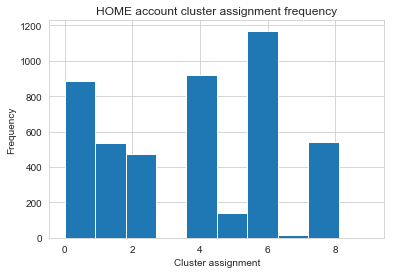

Text(0.5, 1.0, 'COMM account cluster assignment frequency')

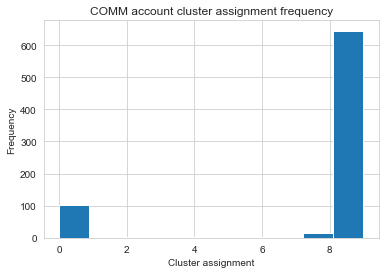

In [333]:

# home has a much more even distribution of cluster assignments than comm!
f, ax = plt.subplots(figsize=(6,4))
sns.set_style('whitegrid')
    
plt.hist(home10['cluster'], bins=10)
plt.xlabel('Cluster assignment')
plt.ylabel('Frequency')
plt.title('HOME account cluster assignment frequency')
plt.show() 

plt.hist(comm10['cluster'], bins=10)
plt.xlabel('Cluster assignment')
plt.ylabel('Frequency')
plt.title('COMM account cluster assignment frequency')

In [338]:
# merge id-level data and cluster assignment
home = pd.merge(readdata[['ID','TARIFF','REVENUCODE','TYPE']].drop_duplicates(), home10, how='inner', on=['ID','TYPE'])
comm = pd.merge(readdata[['ID','TARIFF','REVENUCODE','TYPE']].drop_duplicates(), comm10, how='inner', on=['ID','TYPE'])

In [339]:
# home crosstab tariff vs cluster
pd.crosstab(home.TARIFF,home.cluster)

cluster    0    1    2  3    4    5    6   7    8  9
TARIFF                                              
GH0      690  408  370  2  706  107  916  15  424  1
GH5        1    0    0  0    1    1    1   0    0  0
GH8        5    5    2  0    7    0   15   0    5  0
GHC        0    0    0  0    1    0    0   0    0  0
GR0       33   22   19  0   36    4   34   0   27  0
GR5        0    0    0  0    1    0    1   0    0  0
GR8        2    5    4  0    1    1    1   0    2  0
UGH      155  100   80  0  161   27  201   2   85  0
UGR        5    3    2  0    6    0    9   0    5  0
UH5        0    1    1  0    0    0    0   0    0  0
UHC        0    0    0  0    0    0    1   0    0  0

In [340]:
# commercial crosstab tariff vs cluster
pd.crosstab(comm.TARIFF,comm.cluster)

cluster   0  1  2  3  4  5  6  7  8    9
TARIFF                                  
GC0      19  0  0  1  0  0  0  0  1   78
GCE       0  0  0  0  0  0  0  0  0    2
GHC      52  0  2  0  1  1  1  0  8  360
GHE       0  0  0  0  0  0  0  0  0    8
MVF       0  0  0  0  0  0  0  0  0    1
TFG       0  0  0  0  0  0  0  0  0    7
TFL       2  0  0  0  0  0  0  0  1    3
TSI       1  0  0  0  0  0  0  0  0    2
UGC       7  0  0  0  0  0  0  0  0   43
UHC      21  1  0  0  0  0  0  1  4  141

### Explain home clusters ###

In [385]:
# calculate cluster centroids
data = readdata[(readdata['TYPE']=='HOME')]
data = data.loc[:, data.columns.isin(['ID','TYPE','Dt','Use'])]
data = data.pivot_table(values='Use', index=['ID','TYPE'], columns='Dt').reset_index()
data = pd.merge(data, home10, how='inner', on=['ID','TYPE'])
data = data.drop(columns='TYPE')
data = data.dropna()

home_centroids = data.groupby('cluster').mean().reset_index()

In [386]:
# transition centroids to tall format
home_centroids = pd.melt(home_centroids, id_vars='cluster',var_name='Dt', value_name='Use')

In [387]:
# add weather data
home_centroids = pd.merge(home_centroids, weather, how='inner', on='Dt')

# Add dummy variables for day-of-week
home_centroids = home_centroids.join(pd.get_dummies(home_centroids['Dt'].dt.weekday_name))

# Add dummy variables for holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
dr = pd.date_range(start=min(home_centroids['Dt']), end=max(home_centroids['Dt']))
holidays = cal.holidays(start=dr.min(), end=dr.max())

home_centroids = home_centroids.join(pd.get_dummies(home_centroids['Dt'].isin(holidays)))
home_centroids = home_centroids.rename(columns={True:'Holiday'})
home_centroids = home_centroids.drop(columns=[False])
list(home_centroids)

In [455]:
# run regression per cluster
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from itertools import chain

regr = linear_model.LinearRegression()

# create table of each cluster's regression equations
rTable = pd.DataFrame(index=(['intercept']+list(home_centroids)[3:] + ['MSE','R2']))

# run regressions; add equation to table
for cluster in home_centroids['cluster'].unique():
    data = home_centroids[(home_centroids['cluster']==cluster)]
    X = data.drop(columns=['cluster','Dt','Use'])
    y = data['Use']
    
    # fit the regression model
    regr.fit(X, y)
    
    # extract model coefficients
    intercept = regr.intercept_
    coefs = regr.coef_
    err = mean_squared_error(y, regr.predict(X))
    r2 = regr.score(X,y)
    #print([intercept]+list(chain(coefs))+[err]+[r2])
    rTable['cluster'+str(cluster)] = [intercept]+list(chain(coefs))+[err]+[r2]

rTable = rTable.T

In [456]:
rTable.to_csv(location+'daily_home_clusters.csv')

In [458]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

rTable_scaled = rTable
rTable_scaled[rTable.columns] = scaler.fit_transform(rTable[rTable.columns])

rTable_scaled.to_csv(location+'daily_home_clusters_scaled.csv')

In [459]:
rTable_scaled

intercept   AvgTemp    HighDB     LowDB     Temp1  Temp1delta  \
cluster0   0.276737  0.276737 -0.276737  0.276737 -0.276737   -0.276737   
cluster1   0.313951  0.313951 -0.313951  0.313951 -0.313951   -0.313951   
cluster2   0.428155  0.428155 -0.428155  0.428155 -0.428155   -0.428155   
cluster3  -2.981852 -2.981852  2.981852 -2.981852  2.981852    2.981852   
cluster4   0.250015  0.250015 -0.250015  0.250015 -0.250015   -0.250015   
cluster5   0.166813  0.166813 -0.166813  0.166813 -0.166813   -0.166813   
cluster6   0.409126  0.409126 -0.409126  0.409126 -0.409126   -0.409126   
cluster7   0.576573  0.576573 -0.576573  0.576573 -0.576573   -0.576573   
cluster8   0.318117  0.318117 -0.318117  0.318117 -0.318117   -0.318117   
cluster9   0.242365  0.242365 -0.242365  0.242365 -0.242365   -0.242365   

           HighDB1  HighDB1delta    LowDB1  LowDB1delta    ...       Friday  \
cluster0  0.276737      0.276737 -0.276737    -0.276737    ...    -0.276737   
cluster1  0.313951      0.313951 -0.313951    -0.313951    ...    -0.313951   
cluster2  0.428155      0.428155 -0.428155    -0.428155    ...    -0.428155   
cluster3 -2.981852     -2.981852  2.981852     2.981852    ...     2.981852   
cluster4  0.250015      0.250015 -0.250015    -0.250015    ...    -0.250015   
cluster5  0.166813      0.166813 -0.166813    -0.166813    ...    -0.166813   
cluster6  0.409126      0.409126 -0.409126    -0.409126    ...    -0.409126   
cluster7  0.576573      0.576573 -0.576573    -0.576573    ...    -0.576573   
cluster8  0.318117      0.318117 -0.318117    -0.318117    ...    -0.318117   
cluster9  0.242365      0.242365 -0.242365    -0.242365    ...    -0.242365   

            Monday  Saturday    Sunday  Thursday   Tuesday  Wednesday  \
cluster0 -0.276737 -0.276737 -0.276737 -0.276737 -0.276737  -0.276737   
cluster1 -0.313951 -0.313951 -0.313951 -0.313951 -0.313951  -0.313951   
cluster2 -0.428155 -0.428155 -0.428155 -0.428155 -0.428155  -0.428155   
cluster3  2.981852  2.981852  2.981852  2.981852  2.981852   2.981852   
cluster4 -0.250015 -0.250015 -0.250015 -0.250015 -0.250015  -0.250015   
cluster5 -0.166813 -0.166813 -0.166813 -0.166813 -0.166813  -0.166813   
cluster6 -0.409126 -0.409126 -0.409126 -0.409126 -0.409126  -0.409126   
cluster7 -0.576573 -0.576573 -0.576573 -0.576573 -0.576573  -0.576573   
cluster8 -0.318117 -0.318117 -0.318117 -0.318117 -0.318117  -0.318117   
cluster9 -0.242365 -0.242365 -0.242365 -0.242365 -0.242365  -0.242365   

           Holiday       MSE        R2  
cluster0 -0.087266 -0.002337  0.333245  
cluster1  0.345884 -0.046183  0.320826  
cluster2  0.476750  0.130711  0.309848  
cluster3 -2.654903 -2.158545 -2.990667  
cluster4 -0.180644 -0.057367  0.328102  
cluster5 -0.350432 -0.222295  0.238831  
cluster6  0.078317  0.055518  0.321265  
cluster7  1.190805  0.152672  0.242048  
cluster8  0.191115 -0.137653  0.354503  
cluster9  0.990374  2.285479  0.541999  

[10 rows x 30 columns]

In [ ]:
# PCA
pca2 = PCA(n_components=2, whiten=True)
X_pca_1cw = pca1.fit_transform(data_scaled)
plt.scatter(X_pca_1cw[:,0], X_pca_1cw[:,1], c=iris.target,
alpha=0.8, s=60, marker='o', edgecolors='white')
plt.show()
pca_2cw.explained_variance_ratio_.sum() 

In [ ]:
# visualize cluster identities using PCA on weight vector

In [ ]:
# visualize rate-code identities using PCA on weight vector

In [ ]:
# append cluster ID to daily/hourly set

In [5]:
# close dask cluster (if used)
#cl.close

<bound method LocalCluster.close of LocalCluster('tcp://127.0.0.1:63002', workers=1, ncores=1)>